# Open-Vocabulary Attention Maps (OVAM)


Colab demo of **Open-Vocabulary Attention Maps with Token Optimization for Semantic Segmentation in Diffusion Models**.

[![GitHub](https://img.shields.io/badge/GitHub-vpulab/ovam-blue.svg)](https://github.com/vpulab/ovam/)
[![arXiv](https://img.shields.io/badge/arXiv-2403.14291-b31b1b.svg)](https://arxiv.org/abs/2403.14291)


## 1. Setup

Install ovam from GitHub. Can take a while (~3 mins)

In [ ]:
!pip install git+https://github.com/vpulab/ovam.git -q

Import packages

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from PIL import Image

from ovam import StableDiffusionHooker
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf

Initialize Stable Diffusion V1.5

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
device = get_device() # Choose between cuda and cpu automatically

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## 2. Evaluate OVAM with natural language

Generate an image with Stable Diffusion and store diffusion features for generating attention maps using the Hooker. This hooker catch all needed features related with the generation of cross-attention maps and store them for further generation.

  0%|          | 0/50 [00:00<?, ?it/s]

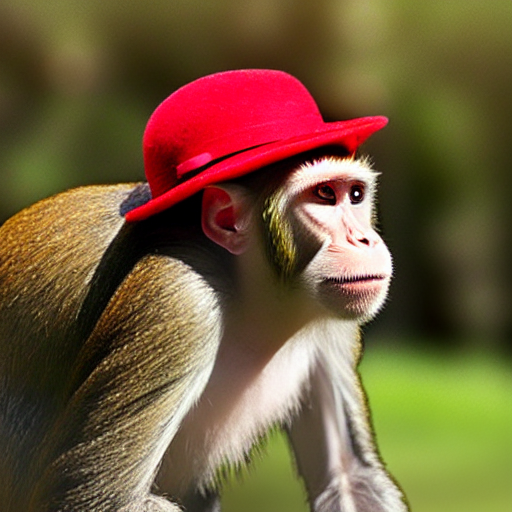

In [4]:
with StableDiffusionHooker(pipe) as hooker:
    set_seed(1)
    out = pipe(prompt="monkey with hat walking")
    image = out.images[0]

image

Generate attention maps using the Hooker. The method get_ovam_callable returns a torch module that can be used to generate attention maps for a given input (string or a tensor with a text embedding).

In [5]:
ovam_evaluator = hooker.get_ovam_callable(
    expand_size=(512, 512)
)  # Here you can configure the OVAM evaluator (aggregation, activations, size, ...)

with torch.no_grad():
    attention_maps = ovam_evaluator("monkey with hat walking and mouth")
    attention_maps = attention_maps[0].cpu().numpy() # (8, 512, 512)

Plot using matplotlib.

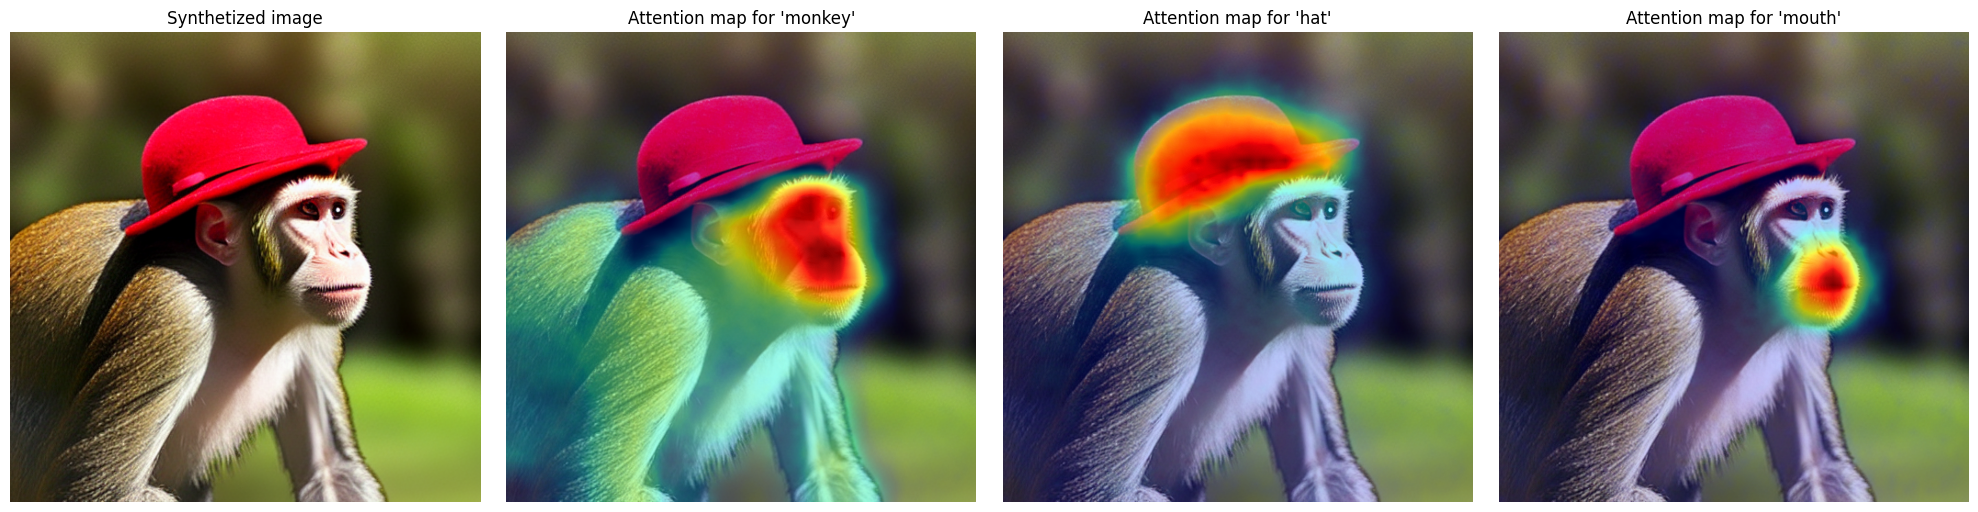

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax in axes:
    ax.axis("off")
    ax.imshow(image)

axes[0].set_title("Synthetized image")
# Tokens: 0:<SoT>, 1:monkey, 2:with, 3:hat, 4:walking, 5:and, 6:mouth, 7:<EoT>
axes[1].set_title("Attention map for 'monkey'")
monkey = attention_maps[1]
axes[1].imshow(monkey, alpha=monkey / monkey.max(), cmap='jet')
axes[2].set_title("Attention map for 'hat'")
hat = attention_maps[3]
axes[2].imshow(hat, alpha=hat / hat.max(), cmap='jet')
axes[3].set_title("Attention map for 'mouth'")
mouth = attention_maps[6]
axes[3].imshow(mouth, alpha=mouth / mouth.max(), cmap='jet')

# Adjust padding and save
fig.tight_layout()

Free attentions allocated, for running example in Colab with limited GPU (the hooker stores all attentions generated during the image synthesis)

In [7]:
del ovam_evaluator
del hooker
torch.cuda.empty_cache()

## 3. Token optimization

A token for a class can be optimized with just a single annotation.


As we need one annotation of an image generated, and different GPUS generate different images for the same seed, we will used the token already optimized for the word cat in the github [demo notebook](https://github.com/vpulab/ovam/blob/main/examples/getting_started.ipynb). See that example on how to optimize a token with one or multiple annotations.


Load optimized token  from GitHub

In [8]:
!wget https://github.com/vpulab/ovam/raw/main/docs/assets/cat_optimized_token.npy -o /content/optimized_token.npy

Convert to tensor

In [9]:
token = np.load("cat_optimized_token.npy")
embedding = torch.tensor(token).to(device)

Generate an image of a cat, plot attentions of the word `cat` and of the optimized token for cat.

  0%|          | 0/30 [00:00<?, ?it/s]

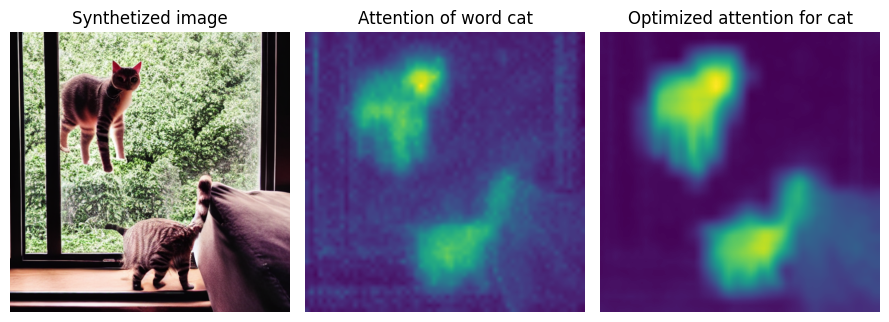

In [10]:
# Generate a new image
with StableDiffusionHooker(pipe) as hooker:
    set_seed(123456)
    out = pipe(prompt="cat perched on the sofa looking out of the window", num_inference_steps=30)
    image = out.images[0]

# Evaluate the attention map with the word cat and the optimized embedding
with torch.no_grad():
    ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))
    optimized_map = ovam_evaluator(embedding).squeeze().cpu().numpy()[1] # (512, 512)
    non_optimized_map = ovam_evaluator("cat").squeeze().cpu().numpy()[1] # (512, 512)

# Plot result using matplotlib
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.set_title("Attention of word cat")
ax1.imshow(non_optimized_map)
ax1.axis('off')
ax2.set_title("Optimized attention for cat")
ax2.imshow(optimized_map)
ax2.axis('off')
fig.tight_layout()

Free memory

In [11]:
del ovam_evaluator
del hooker
torch.cuda.empty_cache()

Binarize mask

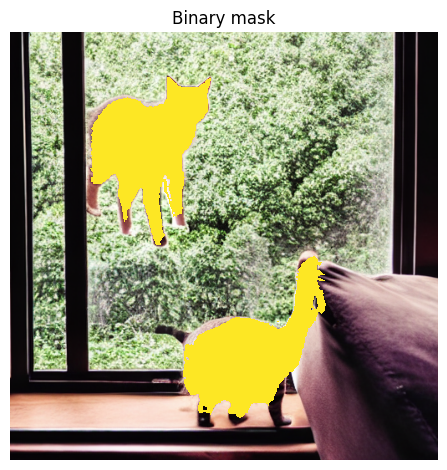

In [17]:
binary_mask = densecrf(np.array(image), optimized_map / optimized_map.max() > 0.5)

fig, ax = plt.subplots(1, 1)
ax.set_title("Binary mask")
ax.axis("off")
ax.imshow(image)
ax.imshow(binary_mask, alpha=binary_mask)
plt.tight_layout()